# COMP7023 (Spring 2024) Predictive Analytics

# Assesment 3

# Group 2

## Nicole Marie Balderama, Mathews Abraham, Manu & Midhun Shyam

In [4]:
# Please ignore. We used google colab for multiple access to files at the same time.
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
# Load Libraries
import pandas as pd
import glob
import numpy as np
import matplotlib.pyplot as plt
import time
import timeit
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression, Ridge, RidgeCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR, LinearSVC, SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, confusion_matrix, roc_curve, roc_auc_score, classification_report,make_scorer
from sklearn.pipeline import Pipeline
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import Adam
import seaborn as sns
import networkx as nx

# Data exploration

In [6]:
# Create a dictionary of DataFrames from all CSV files in the directory
dfs = {file.split('/')[-1].replace('.csv', ''): pd.read_csv(file) for file in glob.glob("drive/MyDrive/Colab Notebooks/PAFinal/*.csv")} # Change path for loading data

print(dfs.keys())

# Get the number of columns and the column names for each dataframe
for name, df in dfs.items():
    num_cols = len(df.columns)
    col_names = df.columns[:]  # Display only the first 5 column names
    print(f"File: {name}")
    print(f"Number of columns: {num_cols}")
    print(f"Columns: {list(col_names)}\n")

dict_keys(['ETF prices', 'MutualFund prices - A-E', 'MutualFund prices - F-K', 'MutualFund prices - L-P', 'MutualFund prices - Q-Z', 'ETFs', 'MutualFunds'])
File: ETF prices
Number of columns: 8
Columns: ['fund_symbol', 'price_date', 'open', 'high', 'low', 'close', 'adj_close', 'volume']

File: MutualFund prices - A-E
Number of columns: 3
Columns: ['fund_symbol', 'price_date', 'nav_per_share']

File: MutualFund prices - F-K
Number of columns: 3
Columns: ['fund_symbol', 'price_date', 'nav_per_share']

File: MutualFund prices - L-P
Number of columns: 3
Columns: ['fund_symbol', 'price_date', 'nav_per_share']

File: MutualFund prices - Q-Z
Number of columns: 3
Columns: ['fund_symbol', 'price_date', 'nav_per_share']

File: ETFs
Number of columns: 142
Columns: ['fund_symbol', 'quote_type', 'region', 'fund_short_name', 'fund_long_name', 'currency', 'fund_category', 'fund_family', 'exchange_code', 'exchange_name', 'exchange_timezone', 'avg_vol_3month', 'avg_vol_10day', 'total_net_assets', 'day

## Relational Database Schema

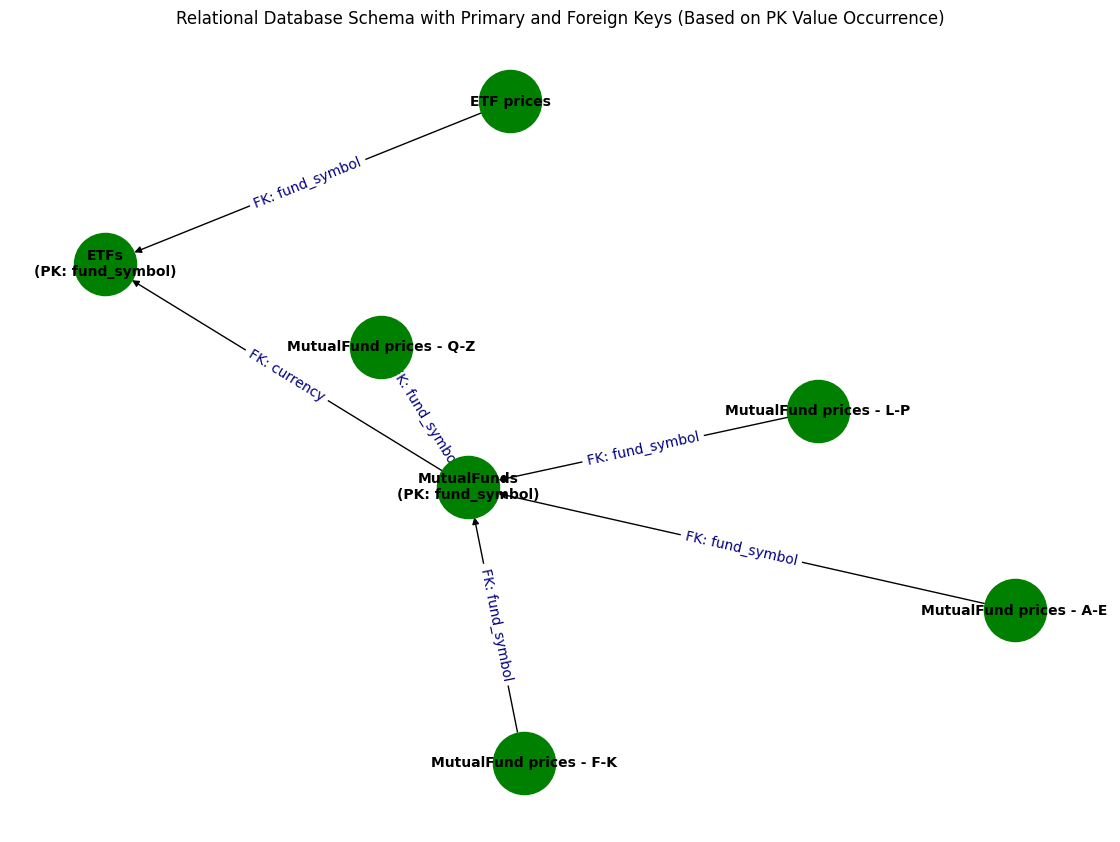

In [9]:
# Identify primary keys (unique non-null columns) and foreign keys (columns where PK values are found in other tables)
primary_keys = {name: next((col for col in df.columns if df[col].is_unique and not df[col].isnull().values.any()), None) for name, df in dfs.items()}

# Now check if the primary key values of one table exist in the columns of other tables
foreign_keys = {}
for name, df in dfs.items():
    foreign_keys[name] = []
    for col in df.columns:
        for other, pk in primary_keys.items():
            if pk and name != other:
                # Check if primary key values from `other` table appear in the current column
                if df[col].isin(dfs[other][pk]).any():
                    foreign_keys[name].append((col, other))

# Build schema plot with NetworkX
G = nx.DiGraph()
node_labels = {name: f"{name}\n(PK: {pk})" if pk else name for name, pk in primary_keys.items()}
edge_labels = {(name, other): f"FK: {col}" for name, rels in foreign_keys.items() for col, other in rels}

# Add nodes and edges to the graph
G.add_nodes_from(dfs.keys())
G.add_edges_from(edge_labels.keys())

# Draw the graph
plt.figure(figsize=(11, 8))
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, labels=node_labels, node_size=2000, node_color='green', font_size=10, font_weight='bold', arrows=True)
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='navy')
plt.title("Relational Database Schema with Primary and Foreign Keys (Based on PK Value Occurrence)")
plt.savefig('schema_plot.png')
plt.show()


##### Even though its a relational database; File: MutualFund prices - A-E, File: MutualFund prices - F-K, File: MutualFund prices - L-P , File: MutualFund prices - Q-Z cannot be joined as it results in crashing for personal laptops. Therefore, ETF prices were also ignored since it would create imbalanced dataset.


In [10]:
# Load the datasets to be used
etf = dfs["ETFs"].dropna(thresh = 0.8*len(dfs["ETFs"]), axis = 1)
print(f'ETFs shape before dropping missing value rows {etf.shape}')
mf = dfs["MutualFunds"].dropna(thresh = 0.8*len(dfs["MutualFunds"]), axis = 1)
print(f'MutualFunds shape before dropping missing value rows {mf.shape}')
mf.dropna(axis =0, inplace = True)
print(f'MutualFunds shape before dropping missing value rows {mf.shape}')
data = pd.concat([etf, mf], join = "inner", axis = 0)
print(f'Data shape {data.shape}')

ETFs shape before dropping missing value rows (2310, 33)
MutualFunds shape before dropping missing value rows (23783, 138)
MutualFunds shape before dropping missing value rows (7862, 138)
Data shape (10172, 31)


<ipython-input-10-ad23670cc77f>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mf.dropna(axis =0, inplace = True)


##### Removing categorical columns with 1 unique value (which is not useful as a feature) and more than 10 unique classes to reduce model complexity.

In [11]:
# List to hold columns with more than 10 unique values
cols_to_drop = []

cat = data.select_dtypes(exclude = ['number']).columns
for col in cat:
    unique_count = len(data[col].unique())
    if unique_count > 10 or unique_count == 1:
        cols_to_drop.append(col)
    print(f"Column '{col}' has {unique_count} unique values.")

# cols_to_drop now contains the names of all columns with more than 10 unique values
print("Columns to drop:", cols_to_drop)

Column 'fund_symbol' has 10172 unique values.
Column 'quote_type' has 2 unique values.
Column 'region' has 1 unique values.
Column 'fund_short_name' has 2680 unique values.
Column 'fund_long_name' has 5355 unique values.
Column 'currency' has 1 unique values.
Column 'fund_family' has 297 unique values.
Column 'exchange_code' has 5 unique values.
Column 'exchange_name' has 5 unique values.
Column 'exchange_timezone' has 1 unique values.
Column 'investment_strategy' has 2004 unique values.
Column 'inception_date' has 3105 unique values.
Column 'top10_holdings' has 2094 unique values.
Column 'returns_as_of_date' has 31 unique values.
Columns to drop: ['fund_symbol', 'region', 'fund_short_name', 'fund_long_name', 'currency', 'fund_family', 'exchange_timezone', 'investment_strategy', 'inception_date', 'top10_holdings', 'returns_as_of_date']


In [12]:
# Print value counts for the specified columns
print(data['exchange_name'].value_counts())
print(data['exchange_code'].value_counts())

exchange_name
Nasdaq       7862
NYSEArca     1436
BATS          475
NasdaqGM      391
Other OTC       8
Name: count, dtype: int64
exchange_code
NAS    7862
PCX    1436
BTS     475
NGM     391
PNK       8
Name: count, dtype: int64


In [13]:
clean = data.drop(cols_to_drop + ["exchange_name", "returns_as_of_date","exchange_code"], axis = 1)
print(clean.isna().sum().sort_values(ascending = False))

fund_return_1year                       393
fund_return_ytd                         201
top10_holdings_total_assets             138
fund_return_3months                     136
fund_return_1month                       78
total_net_assets                         30
week52_low_change_perc                   16
week52_low_change                        16
fund_annual_report_net_expense_ratio     15
week52_high_change                        3
week52_high_change_perc                   3
week52_low                                1
week52_high                               1
week52_high_low_change_perc               1
week52_high_low_change                    1
day200_moving_average                     1
day50_moving_average                      1
quote_type                                0
dtype: int64


### "returns_as_of_date" were removed because return as of dates has only values [1970 ,1993, 2001], also exchange code was removed because of class imbalance for PNK with only 8 observations

### Removing outliers

In [14]:
# Select categorical columns
categorical_columns = clean.select_dtypes(include = ['object']).columns

# Select numerical columns
numerical_columns = clean.columns.difference(categorical_columns)

# Compute Q3 for numerical columns
Q3 = clean[numerical_columns].quantile(0.75)

# Compute the threshold for outliers
threshold = 1.5 * Q3

# Find rows where any numerical feature exceeds the threshold
outliers = (clean[numerical_columns] > threshold).any(axis = 1)

# Print total number of outliers
print("Total Outliers:", outliers.sum())

# Remove outliers from the DataFrame
clean_filtered = clean[~outliers]

# Compute data loss
data_loss = (clean.shape[0] - clean_filtered.shape[0]) / clean.shape[0] * 100
print(f'Retained Data: {clean_filtered.shape[0]} / {clean.shape[0]} ({100 - data_loss:.2f} % )')
print(clean_filtered['quote_type'].value_counts())

Total Outliers: 8411
Retained Data: 1761 / 10172 (17.31 % )
quote_type
MutualFund    1392
ETF            369
Name: count, dtype: int64


In [15]:
clean_filtered = pd.concat([
    clean_filtered[clean_filtered['quote_type'] == "ETF"],
    clean_filtered[clean_filtered['quote_type'] == "MutualFund"].sample(n=len(clean_filtered[clean_filtered['quote_type'] == "ETF"]))
])

print("Balanced data class count:\n", clean_filtered['quote_type'].value_counts())

Balanced data class count:
 quote_type
ETF           369
MutualFund    369
Name: count, dtype: int64


In [16]:
clean_filtered.isna().sum().sort_values(ascending = False)

fund_return_1year                       75
fund_return_ytd                         47
fund_return_3months                     40
top10_holdings_total_assets             26
fund_return_1month                      23
total_net_assets                        10
fund_annual_report_net_expense_ratio     3
week52_low_change_perc                   1
week52_low_change                        1
quote_type                               0
week52_high_change_perc                  0
week52_high_change                       0
week52_high                              0
week52_high_low_change_perc              0
week52_high_low_change                   0
day200_moving_average                    0
day50_moving_average                     0
week52_low                               0
dtype: int64

## K-Nearest Neighbour Imputation for missing values

In [17]:
# Separate numerical and categorical columns
numerical_cols = clean_filtered.select_dtypes(include = ['number'])  # numeric columns
categorical_cols = clean_filtered.select_dtypes(exclude = ['number'])  # non-numeric columns

# Compute the mean and std of the original numerical data
original_means = numerical_cols.mean()
original_stds = numerical_cols.std()

# Identify columns with std deviation greater than 1
cols_to_scale = original_stds[original_stds > 1].index

# Scale only those numerical data columns where std deviation > 1
scaler = StandardScaler()
scaled_numerical = numerical_cols.copy()
scaled_numerical[cols_to_scale] = scaler.fit_transform(numerical_cols[cols_to_scale])

# Apply KNN imputer to the numerical data
imputer = KNNImputer(n_neighbors = 5)
imputed_data = imputer.fit_transform(scaled_numerical)
imputed_numerical = pd.DataFrame(imputed_data, columns = numerical_cols.columns)

# Reverse the scaling for the scaled columns
imputed_numerical[cols_to_scale] = scaler.inverse_transform(imputed_numerical[cols_to_scale])

# Compute the mean and std of the imputed data
imputed_means = imputed_numerical.mean()
imputed_stds = imputed_numerical.std()

# Compute the changes in mean and std after imputation and print them
change_in_means = imputed_means - original_means
change_in_stds = imputed_stds - original_stds

# Recombine the numerical and categorical data into one DataFrame
clean_imputed = pd.concat([imputed_numerical.reset_index(drop = True), categorical_cols.reset_index(drop = True)], axis = 1)

# Print the original, imputed means and stds, and their changes for each feature
print("Changes in Means and Standard Deviations after Imputation:")
for column in numerical_cols.columns:
    print(f"\nFeature: {column}")
    print(f"Original Mean: {original_means[column]:.2f}, Imputed Mean: {imputed_means[column]:.2f}")
    print(f"Change in Mean: {imputed_means[column] - original_means[column]:.2f}")
    print(f"Original Std: {original_stds[column]:.2f}, Imputed Std: {imputed_stds[column]:.2f}")
    print(f"Change in Std: {imputed_stds[column] - original_stds[column]:.2f}")



Changes in Means and Standard Deviations after Imputation:

Feature: total_net_assets
Original Mean: 584053283.45, Imputed Mean: 581912197.32
Change in Mean: -2141086.13
Original Std: 864575427.33, Imputed Std: 859540985.24
Change in Std: -5034442.09

Feature: day50_moving_average
Original Mean: 25.75, Imputed Mean: 25.75
Change in Mean: 0.00
Original Std: 9.09, Imputed Std: 9.09
Change in Std: 0.00

Feature: day200_moving_average
Original Mean: 25.57, Imputed Mean: 25.57
Change in Mean: 0.00
Original Std: 8.98, Imputed Std: 8.98
Change in Std: 0.00

Feature: week52_high_low_change
Original Mean: 5.23, Imputed Mean: 5.23
Change in Mean: 0.00
Original Std: 2.56, Imputed Std: 2.56
Change in Std: 0.00

Feature: week52_high_low_change_perc
Original Mean: 0.19, Imputed Mean: 0.19
Change in Mean: 0.00
Original Std: 0.06, Imputed Std: 0.06
Change in Std: 0.00

Feature: week52_high
Original Mean: 27.61, Imputed Mean: 27.61
Change in Mean: 0.00
Original Std: 9.70, Imputed Std: 9.70
Change in St

In [18]:
print(clean_imputed.describe())

       total_net_assets  day50_moving_average  day200_moving_average  \
count      7.380000e+02            738.000000             738.000000   
mean       5.819122e+08             25.747394              25.571833   
std        8.595410e+08              9.090109               8.984086   
min        2.196550e+05              5.277000               5.755000   
25%        4.092146e+07             18.204500              17.934500   
50%        2.027236e+08             25.929500              25.782500   
75%        6.775327e+08             31.768000              31.638000   
max        3.792959e+09             53.578000              52.540000   

       week52_high_low_change  week52_high_low_change_perc  week52_high  \
count              738.000000                   738.000000   738.000000   
mean                 5.228449                     0.187621    27.609524   
std                  2.563049                     0.057088     9.704414   
min                  1.200000                     0

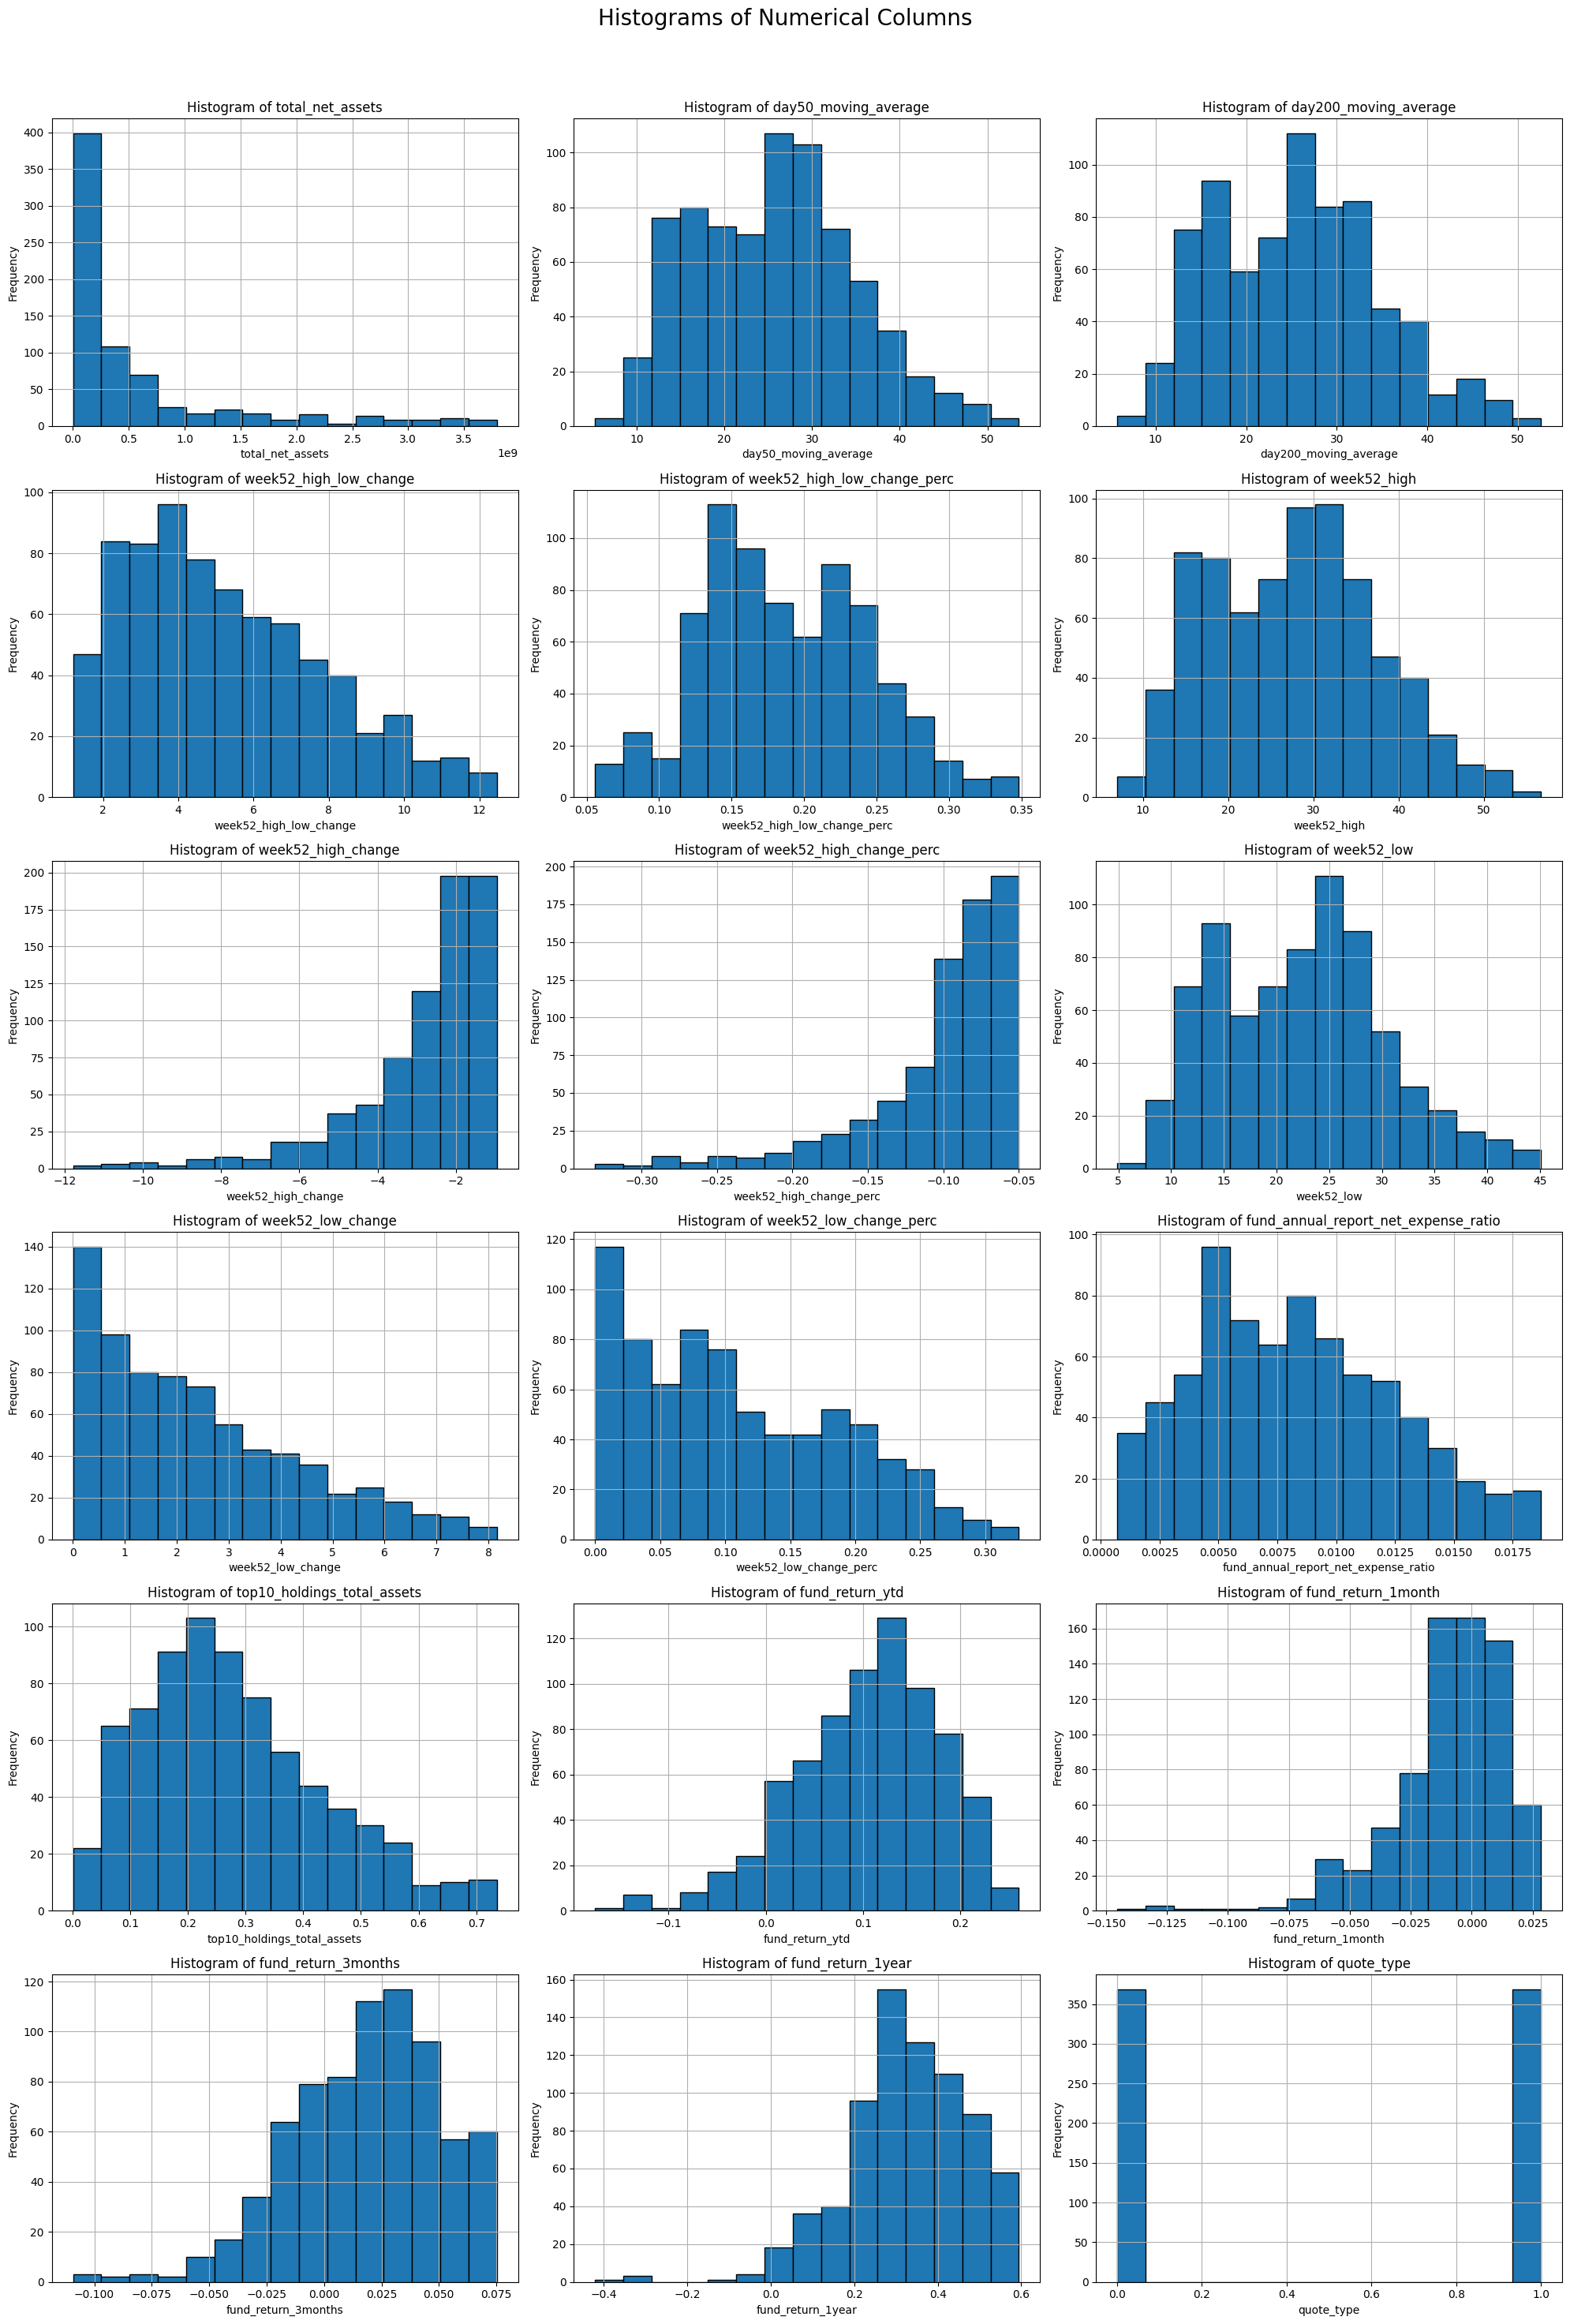

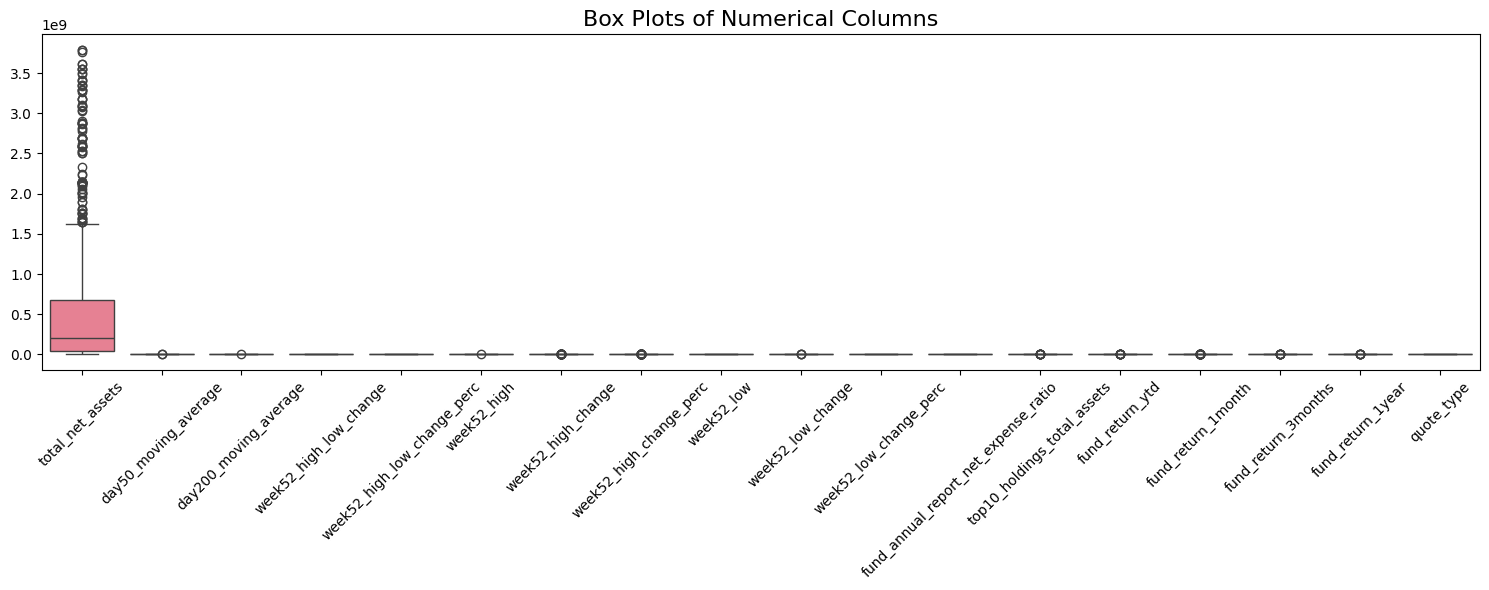

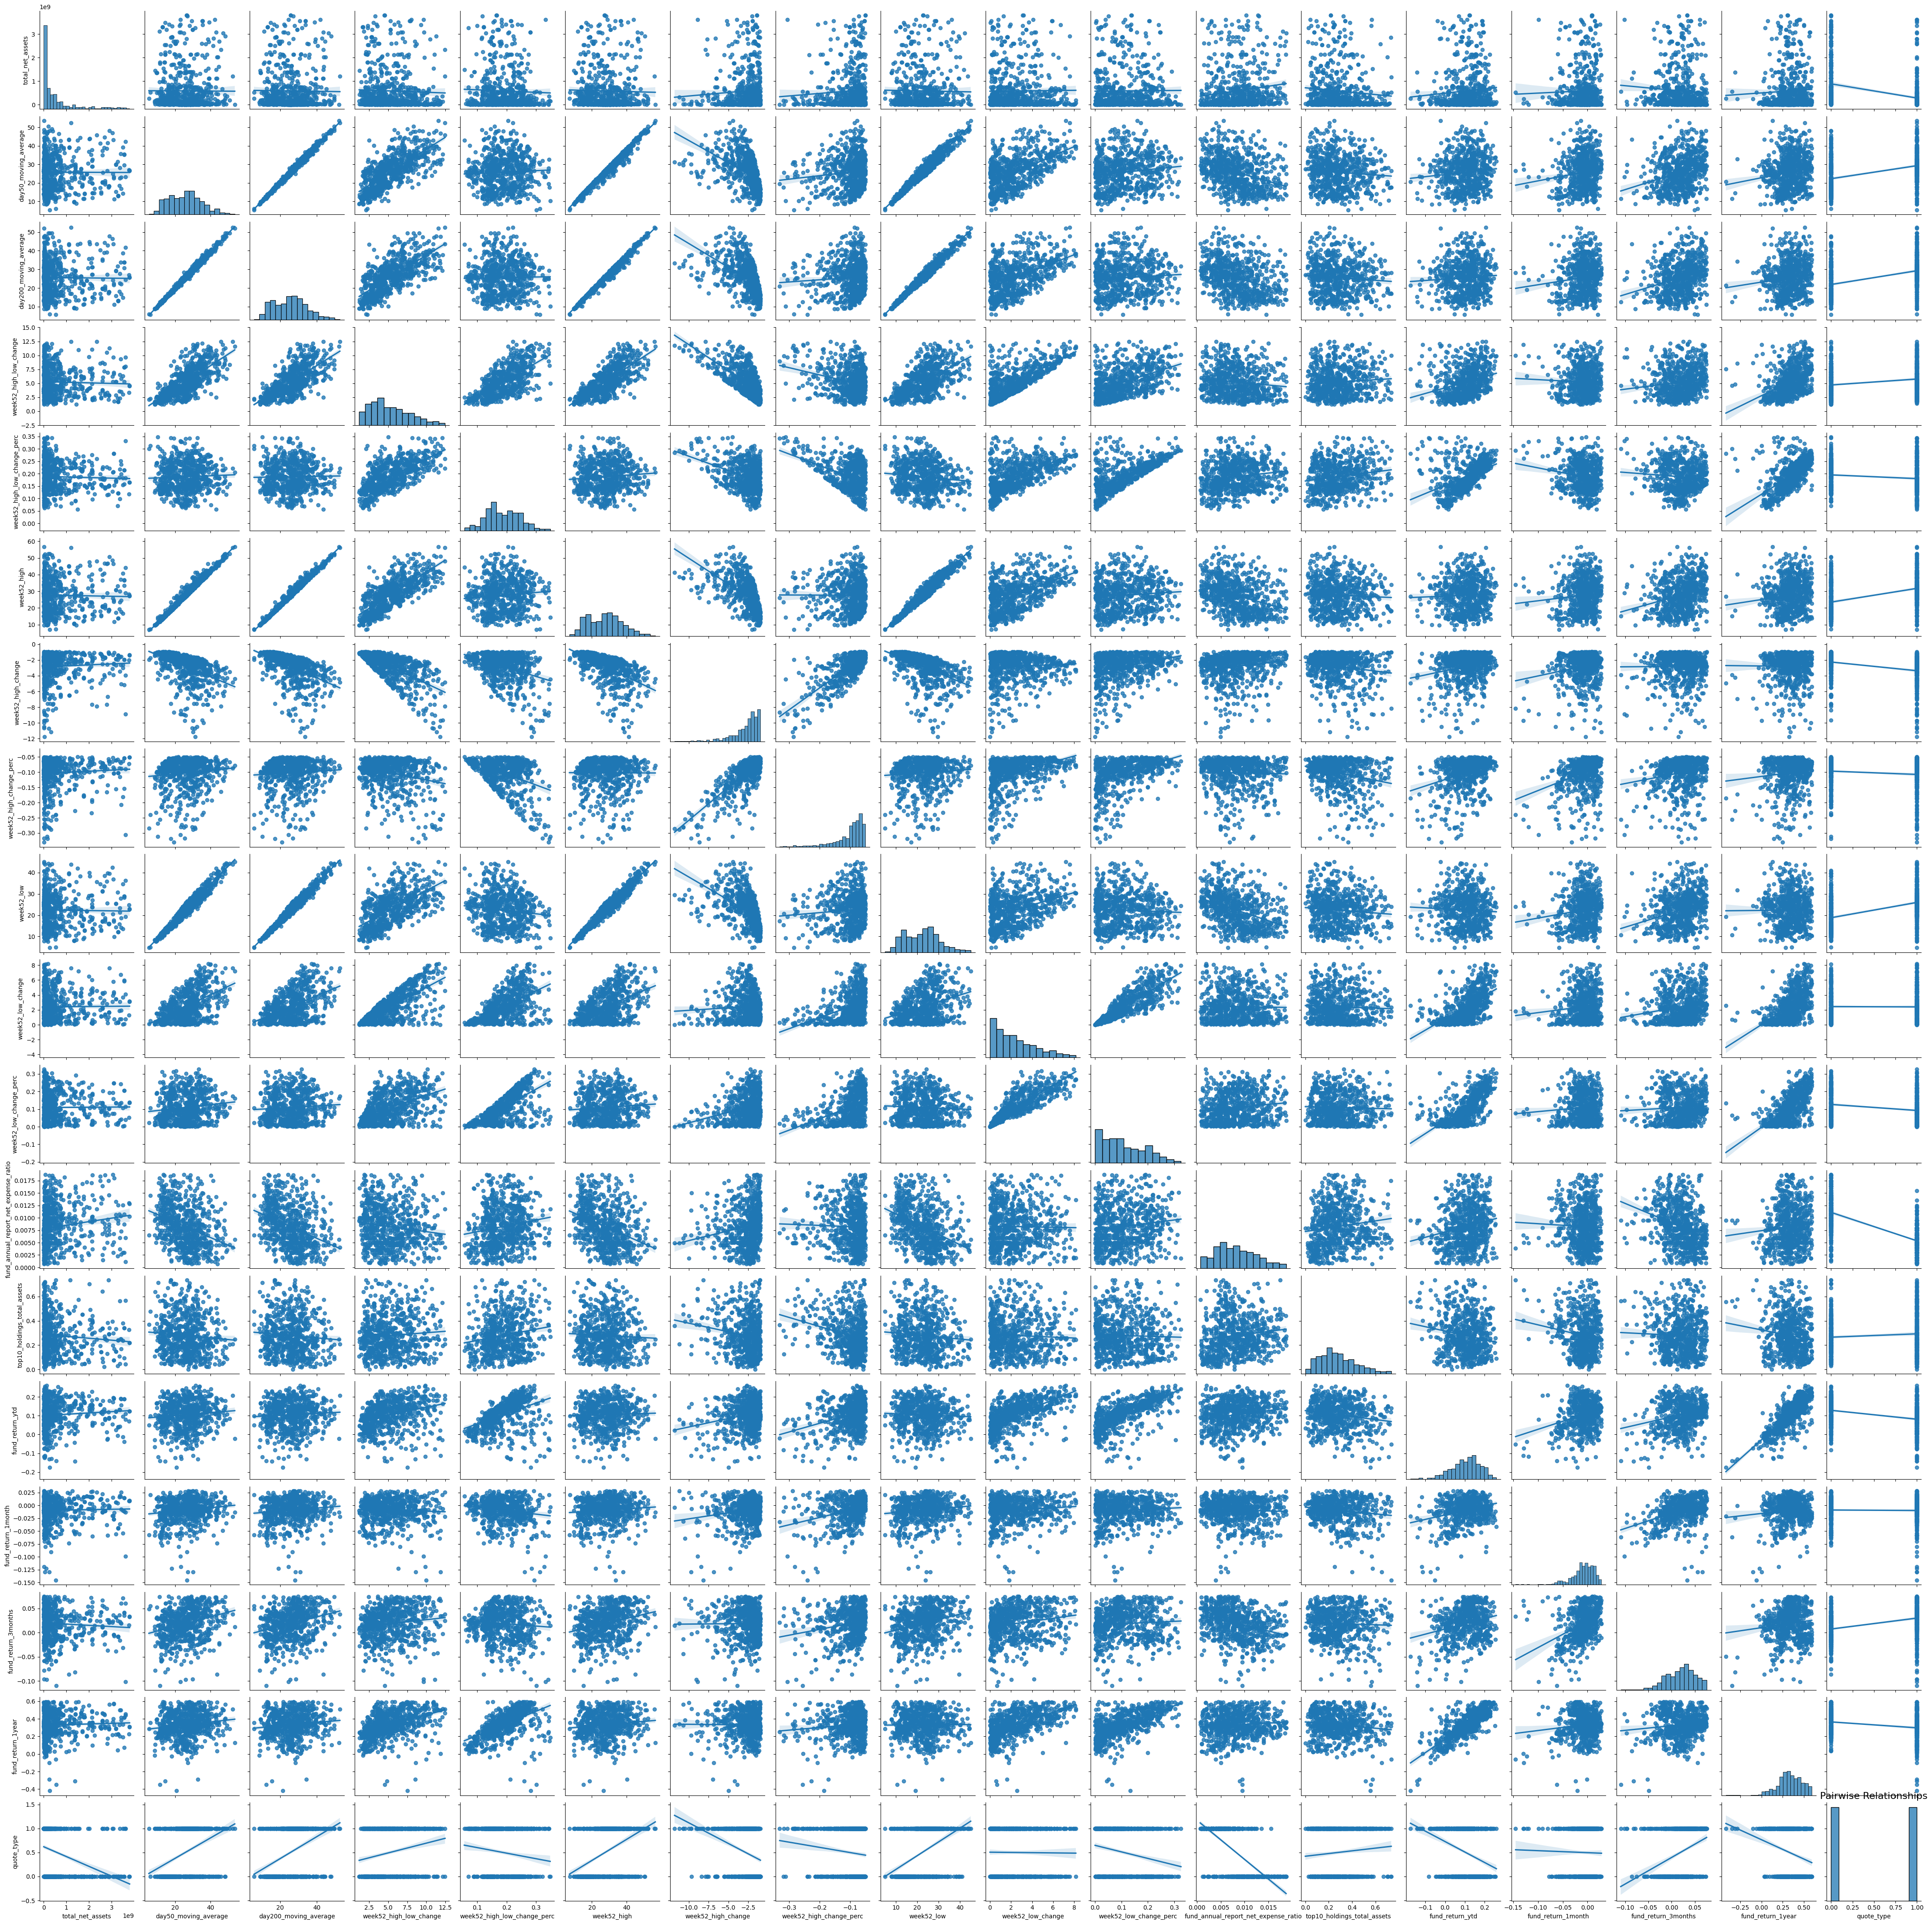

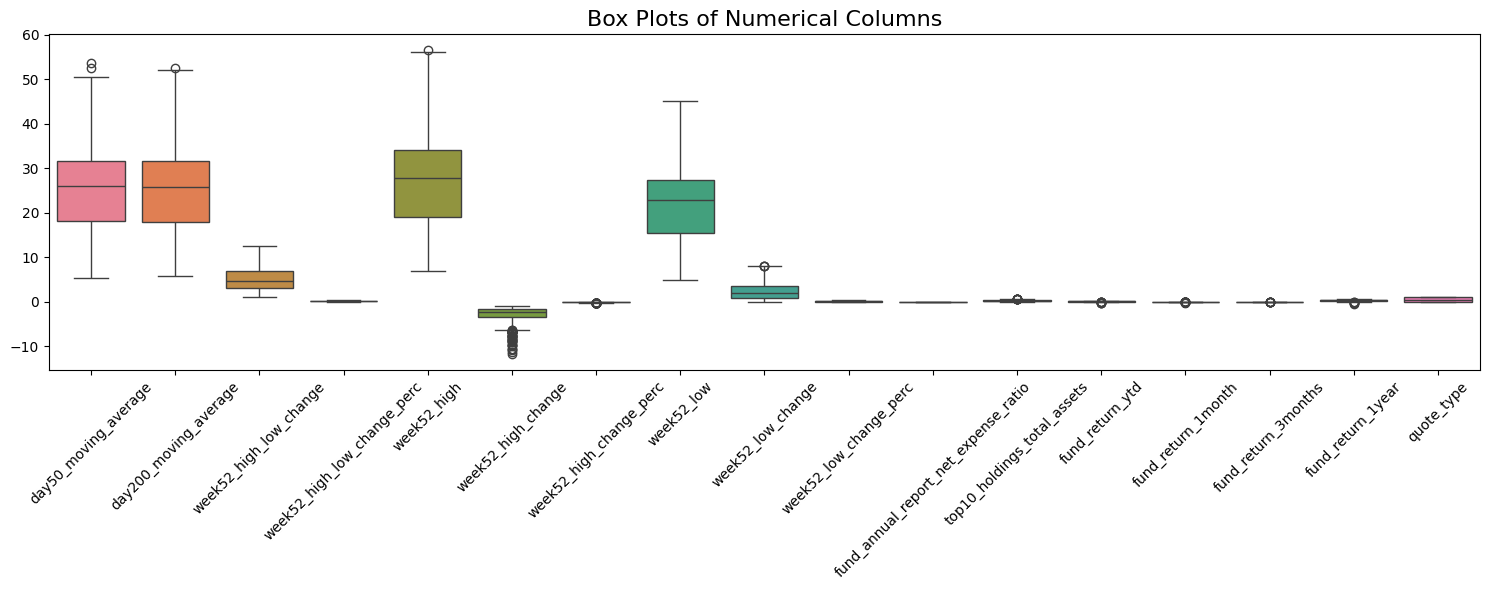

In [36]:
numerical_columns = clean_imputed.select_dtypes(include=['float64', 'int64']).columns

num_cols = len(numerical_columns)
n_rows = (num_cols // 3) + (num_cols % 3 > 0)  # Calculate the number of rows needed
plt.figure(figsize=(20, 5 * n_rows))

# Histogram plots
plt.subplot(n_rows, 3, 1)
for i, column in enumerate(numerical_columns):
    plt.subplot(n_rows, 3, i + 1)
    clean_imputed[column].hist(bins=15, edgecolor='black')
    plt.title(f'Histogram of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')

plt.suptitle('Histograms of Numerical Columns', fontsize=20)
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust title space

# Box plots
plt.figure(figsize=(15, 6))
sns.boxplot(data=clean_imputed[numerical_columns])
plt.title('Box Plots of Numerical Columns', fontsize=16)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Pair plots
sns.pairplot(clean_imputed[numerical_columns], kind='reg')
plt.title('Pairwise Relationships', fontsize=16)
plt.show()


# Update the list of numerical columns to exclude 'total_net_assets'
numerical_columns_excluding = [col for col in numerical_columns if col != 'total_net_assets']

# Create box plots for the numerical columns excluding 'total_net_assets'
plt.figure(figsize=(15, 6))
sns.boxplot(data=clean_imputed[numerical_columns_excluding])
plt.title('Box Plots of Numerical Columns', fontsize=16)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Modeling



# 1. Classification

#### Target variable = quote_type

In [22]:
## Feature extraction and selection
features = clean_imputed.drop(['quote_type'], axis = 1 )
clean_imputed['quote_type'] = clean_imputed['quote_type'].map({'ETF': 1, 'MutualFund': 0})
target = clean_imputed['quote_type']

In [23]:
X = np.c_[features]
y = np.c_[target].flatten()

print(X.shape)
print(y.shape)
print(clean_imputed.shape)

(738, 17)
(738,)
(738, 18)


## Neural Network

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

# Scale the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype = torch.float32)
X_test = torch.tensor(X_test, dtype = torch.float32)
y_train = torch.tensor(y_train, dtype = torch.float32)
y_test = torch.tensor(y_test, dtype = torch.float32)

# Create datasets
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size = 64, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size = 64, shuffle = False)

In [25]:
# Define the neural network architecture
class BinaryClassifier(nn.Module):
    def __init__(self):
        super(BinaryClassifier, self).__init__()
        self.layer1 = nn.Linear(17, 64)
        self.relu = nn.ReLU()
        self.layer2 = nn.Linear(64, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.layer1(x)
        x = self.relu(x)
        x = self.layer2(x)
        x = self.sigmoid(x)
        return x

# Initialise the model, loss criterion, and optimizer
model = BinaryClassifier()
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)

Epoch 1, Loss: 0.6595
Epoch 101, Loss: 0.0948
Epoch 201, Loss: 0.0595
Epoch 301, Loss: 0.0362
Epoch 401, Loss: 0.0217
Epoch 501, Loss: 0.0133
Epoch 601, Loss: 0.0072
Epoch 701, Loss: 0.0043
Epoch 801, Loss: 0.0024
Epoch 901, Loss: 0.0012
Training Time: 29.27 seconds


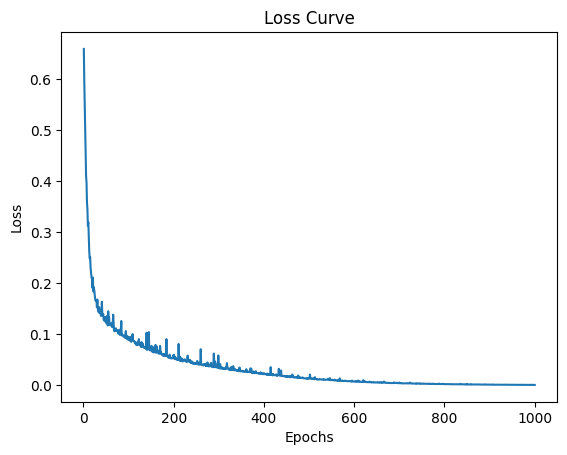

Testing Time: 0.01 seconds
Classification Report:
              precision    recall  f1-score   support

         0.0       0.97      0.97      0.97        69
         1.0       0.97      0.97      0.97        79

    accuracy                           0.97       148
   macro avg       0.97      0.97      0.97       148
weighted avg       0.97      0.97      0.97       148

Confusion Matrix:
[[67  2]
 [ 2 77]]
Accuracy: 97.30%


In [26]:
# Measure training time
start_training_time = time.time()
losses = []   # store loss values for each epoch

# Training loop
num_epochs = 1000
for epoch in range(num_epochs):
    epoch_loss = 0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    # Average loss for the epoch
    epoch_loss /= len(train_loader)
    losses.append(epoch_loss)
    if epoch % 100 == 0:
      print(f'Epoch {epoch+1}, Loss: {epoch_loss:.4f}')

# Total time for training
end_training_time = time.time()
training_time = end_training_time - start_training_time
print(f'Training Time: {training_time:.2f} seconds')

# Plot the loss curve
plt.plot(range(1, num_epochs+1), losses)
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

# Measure testing time
start_testing_time = time.time()

# Test the model
model.eval()
all_labels = []
all_preds = []

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        predicted = (outputs.squeeze() > 0.5).float()
        all_labels.extend(labels.tolist())
        all_preds.extend(predicted.tolist())

# Total time for testing
end_testing_time = time.time()
testing_time = end_testing_time - start_testing_time
print(f'Testing Time: {testing_time:.2f} seconds')

# Convert lists to numpy arrays
all_labels = np.array(all_labels)
all_preds = np.array(all_preds)

# Classification report
print("Classification Report:")
print(classification_report(all_labels, all_preds))

# Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(all_labels, all_preds))

# Accuracy score
accuracy = accuracy_score(all_labels, all_preds)
print(f'Accuracy: {accuracy * 100:.2f}%')

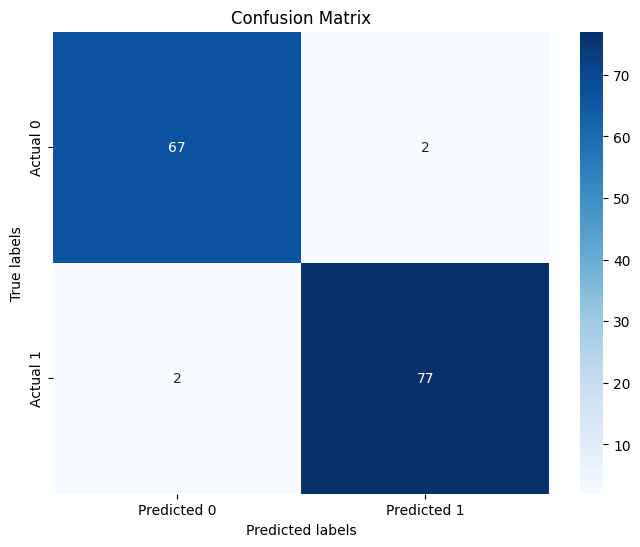

In [27]:
# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(all_labels, all_preds), annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

#Support Vector Machines
## SVC

C = 0.01 (LinearSVC), accuracy = 95.94594594594594
C = 0.1 (LinearSVC), accuracy = 96.62162162162163
C = 1 (LinearSVC), accuracy = 96.62162162162163
C = 10 (LinearSVC), accuracy = 95.27027027027027
C = 100 (LinearSVC), accuracy = 95.27027027027027
Time to run the RBF SVM training for C=0.01: 0.028833856999995078 seconds
C = 0.01 (RBF SVM), accuracy = 58.78378378378378
Time to run the RBF SVM training for C=0.1: 0.01698580800007221 seconds
C = 0.1 (RBF SVM), accuracy = 88.51351351351352
Time to run the RBF SVM training for C=1: 0.011698051000053056 seconds
C = 1 (RBF SVM), accuracy = 95.94594594594594
Time to run the RBF SVM training for C=10: 0.012818005999974957 seconds
C = 10 (RBF SVM), accuracy = 97.2972972972973
Time to run the RBF SVM training for C=100: 0.013980563000018265 seconds
C = 100 (RBF SVM), accuracy = 95.27027027027027


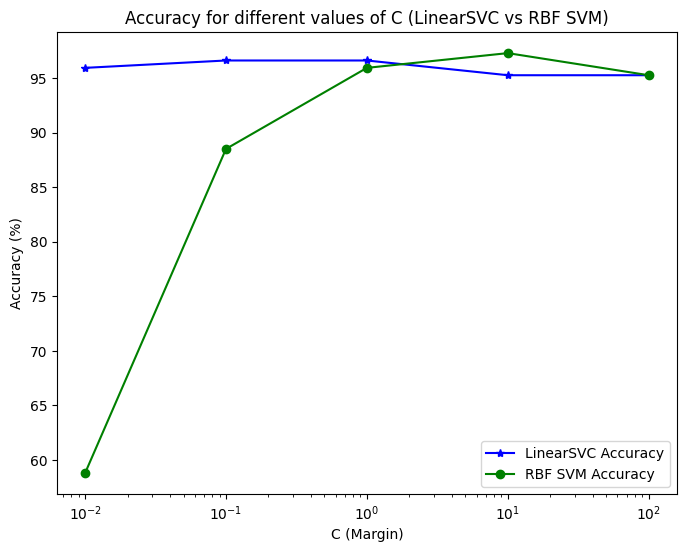

Time to run the final RBF SVM training with best C=10: 0.017539223000085258 seconds
Confusion Matrix for Best RBF SVM Model:
 [[68  1]
 [ 3 76]]
Final RBF SVM accuracy for C=10: 97.30%


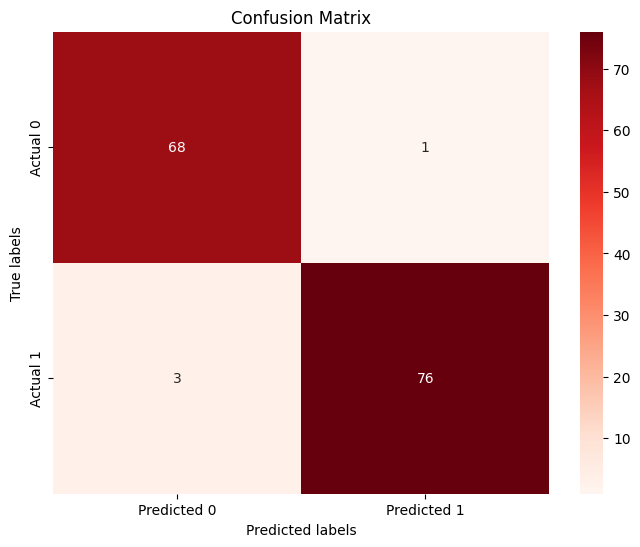

In [28]:
# Initialise parameters for C values
Margins = [0.01, 0.1, 1, 10, 100]
linear_svc_accuracy = []
rbf_svc_accuracy = []

# Linear SVM with different margins (C values)
for m in Margins:
    # Initialise LinearSVC with hinge loss
    svm_clf_cv = LinearSVC(C=m, max_iter=int(1e4))

    # Train the model on the training set
    svm_clf_cv.fit(X_train, y_train)

    # Predict on the test set
    y_pred = svm_clf_cv.predict(X_test)

    # Compute accuracy
    accCurr = accuracy_score(y_test, y_pred) * 100
    print(f'C = {m} (LinearSVC), accuracy = {accCurr}')

    # Store the accuracy for plotting
    linear_svc_accuracy.append(accCurr)

# RBF kernel SVM with different C values
for m in Margins:
    # Initialise SVC with RBF kernel and varying C
    svm_clf_rbf = SVC(kernel = "rbf", gamma = 'scale', C = m, max_iter = int(1e4))

    # Measure training time
    start = timeit.default_timer()
    svm_clf_rbf.fit(X_train, y_train)
    stop = timeit.default_timer()
    timeTaken = stop - start
    print(f'Time to run the RBF SVM training for C={m}: {timeTaken} seconds')

    # Prediction on the test set
    y_pred_rbf = svm_clf_rbf.predict(X_test)

    # Compute accuracy
    accCurr_rbf = accuracy_score(y_test, y_pred_rbf) * 100
    print(f'C = {m} (RBF SVM), accuracy = {accCurr_rbf}')

    # Store the accuracy for plotting
    rbf_svc_accuracy.append(accCurr_rbf)

# Combined plot for Linear SVC and RBF SVM
plt.figure(figsize = (8, 6))
plt.semilogx(Margins, linear_svc_accuracy, '*-', label = "LinearSVC Accuracy", color = 'blue')
plt.semilogx(Margins, rbf_svc_accuracy, 'o-', label = "RBF SVM Accuracy", color = 'green')
plt.xlabel('C (Margin)')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy for different values of C (LinearSVC vs RBF SVM)')
plt.legend()
plt.show()

# Print final RBF SVM accuracy
best_rbf_C = Margins[np.argmax(rbf_svc_accuracy)]
svm_clf_best_rbf = SVC(kernel="rbf", gamma='scale', C=best_rbf_C, max_iter=int(1e4))

# Measure training time for the best RBF model
start = timeit.default_timer()
svm_clf_best_rbf.fit(X_train, y_train)
stop = timeit.default_timer()
timeTaken_best_rbf = stop - start
print(f'Time to run the final RBF SVM training with best C={best_rbf_C}: {timeTaken_best_rbf} seconds')

# Prediction with best RBF SVM
y_pred_best_rbf = svm_clf_best_rbf.predict(X_test)

# Confusion matrix for the best RBF SVM
conf_matrix_best_rbf = confusion_matrix(y_test, y_pred_best_rbf)
print('Confusion Matrix for Best RBF SVM Model:\n', conf_matrix_best_rbf)

# Final accuracy for the best RBF SVM
final_accuracy_best_rbf = accuracy_score(y_test, y_pred_best_rbf) * 100
print(f'Final RBF SVM accuracy for C={best_rbf_C}: {final_accuracy_best_rbf:.2f}%')


# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_best_rbf, annot=True, fmt='d', cmap='Reds', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

# Naives Bayes classifier

Training Accuracy: 88.18%
Test Accuracy: 84.23%
First 20 predictions: [0 1 1 0 1 1 0 1 0 0 0 1 0 0 0 0 0 0 1 1]
Confusion Matrix:
 [[ 87  12]
 [ 23 100]]
Cross-Validation Accuracy: 61.92%


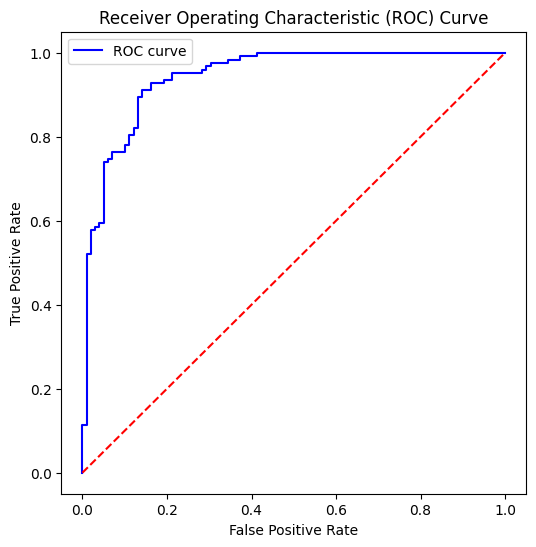

ROC AUC Score: 0.94


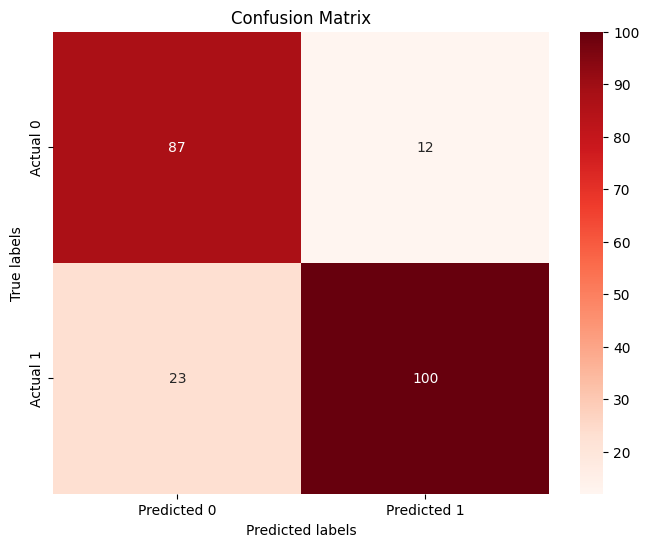

In [29]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

X_train, X_test = scaler.fit_transform(X_train), scaler.transform(X_test)

# Initialize the Gaussian Naive Bayes model
model = GaussianNB()

# Train the model
model.fit(X_train, y_train)

# Model evaluation on the training set
train_score = model.score(X_train, y_train)
print(f'Training Accuracy: {train_score * 100:.2f}%')

# Model evaluation on the test set
test_score = model.score(X_test, y_test)
print(f'Test Accuracy: {test_score * 100:.2f}%')

# Predict the first 20 labels of the test set
y_pred = model.predict(X_test)
print(f'First 20 predictions: {y_pred[:20]}')

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print('Confusion Matrix:\n', conf_matrix)

# Cross-validation score
cv_scores = cross_val_score(GaussianNB(), X, y, cv=5)
print(f'Cross-Validation Accuracy: {cv_scores.mean() * 100:.2f}%')

# Predict probabilities on the test set
y_pred_prob = model.predict_proba(X_test)

# Use the second class as the positives (this is typical in binary classification)
probs = y_pred_prob[:, 1]

# ROC Curve calculation
fper, tper, thresholds = roc_curve(y_test, probs)

# Plot ROC curve
plt.figure(figsize=(6, 6))
plt.plot(fper, tper, color='blue', label='ROC curve')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

# Calculate the area under the ROC curve (AUC)
roc_auc = roc_auc_score(y_test, probs)
print(f'ROC AUC Score: {roc_auc:.2f}')


# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

## 2. Regression

## Target variable - fund_return_ytd

In [30]:
X_dummy = pd.get_dummies(data=clean_imputed, drop_first=True)
features = X_dummy.drop(["fund_return_ytd"],axis =1)
target = X_dummy['fund_return_ytd']
X = np.c_[features]
y = np.c_[target].flatten()

print(X.shape)
print(y.shape)

(738, 17)
(738,)


## Ridge Lasso Regression

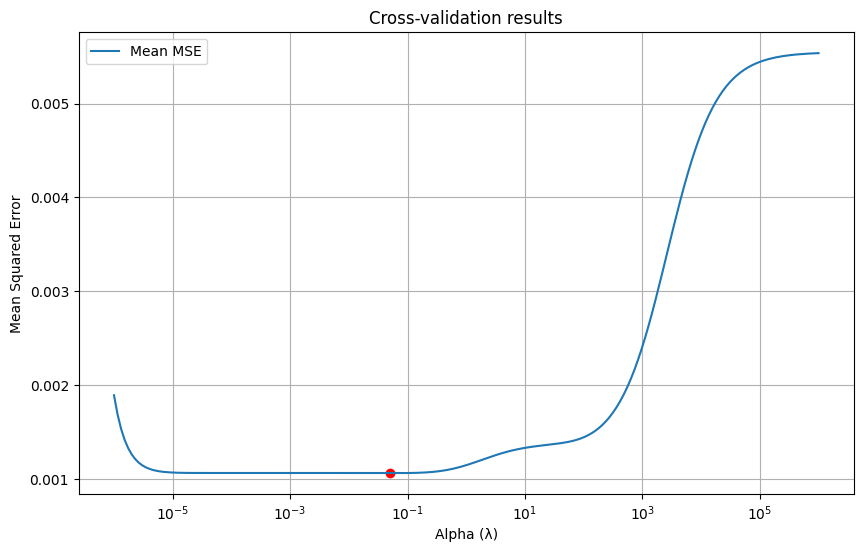

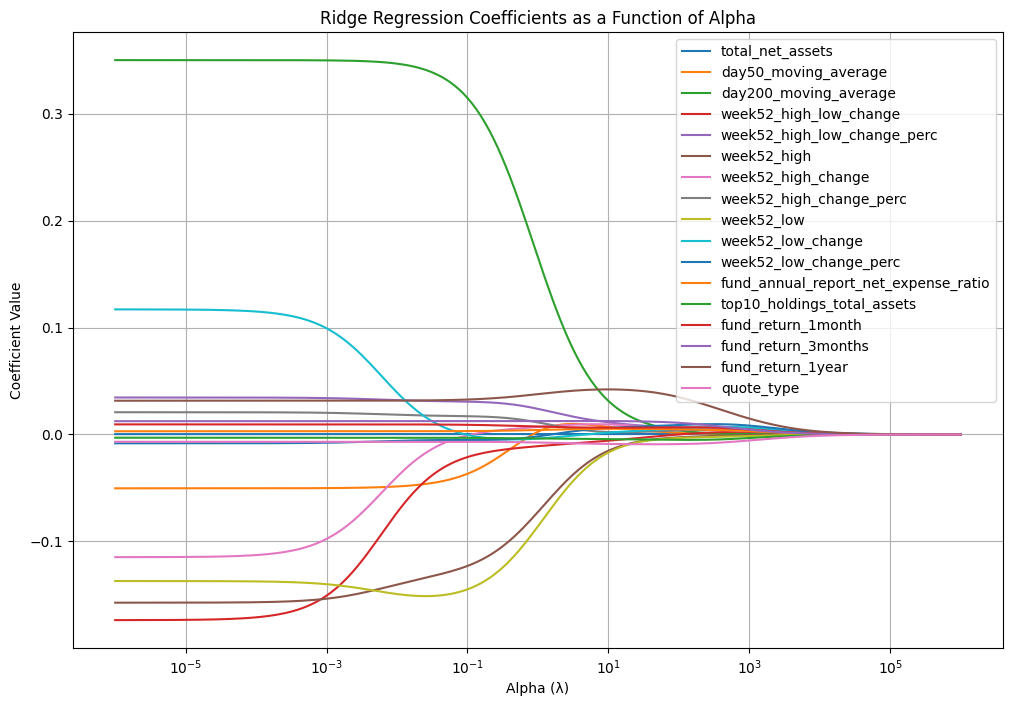

Significant features based on the last set of coefficients:
['total_net_assets', 'day50_moving_average', 'day200_moving_average', 'week52_high_low_change', 'week52_high_low_change_perc', 'week52_high', 'week52_high_change', 'week52_high_change_perc', 'week52_low', 'week52_low_change', 'week52_low_change_perc', 'fund_annual_report_net_expense_ratio', 'top10_holdings_total_assets', 'fund_return_1month', 'fund_return_3months', 'fund_return_1year', 'quote_type']
Best Alpha: 0.0505263106533568
The Mean Squared Error for the training data is 0.0010
The Mean Squared Error for the test data is 0.0010
The R-squared score for the training data is 0.8246
The R-squared score for the test data is 0.8084


In [31]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Define a range of alpha values for Ridge Regression
alphas = np.logspace(-6, 6, 200)
mean_mse_scores = []

# Loop over alphas to manually perform cross-validation
for alpha in alphas:
    ridge_reg = Ridge(alpha=alpha)
    mse_scores = cross_val_score(ridge_reg, X_train, y_train, cv=10, scoring='neg_mean_squared_error')
    mean_mse_scores.append(-np.mean(mse_scores))  # Convert to positive MSE

# Plot MSE values as a function of alpha
plt.figure(figsize=(10, 6))
plt.plot(alphas, mean_mse_scores, label='Mean MSE')
plt.scatter(alphas[np.argmin(mean_mse_scores)], min(mean_mse_scores), color='red')  # Highlight the best alpha
plt.xscale('log')
plt.xlabel('Alpha (λ)')
plt.ylabel('Mean Squared Error')
plt.title('Cross-validation results')
plt.legend()
plt.grid(True)
plt.show()

# Initialize Ridge with the best alpha and fit the model
best_alpha = alphas[np.argmin(mean_mse_scores)]
ridge_reg = Ridge(alpha=best_alpha)
ridge_reg.fit(X_train, y_train)

# Optionally, plot the coefficients as a function of alpha
ridge_coefs = []
for alpha in alphas:
    ridge = Ridge(alpha=alpha)
    ridge.fit(X_train, y_train)
    ridge_coefs.append(ridge.coef_.flatten())

plt.figure(figsize=(12, 8))

for i, feature_name in enumerate(features.columns):
    plt.plot(alphas, [coef[i] for coef in ridge_coefs], label=feature_name)

plt.xlabel('Alpha (λ)')
plt.ylabel('Coefficient Value')
plt.title('Ridge Regression Coefficients as a Function of Alpha')
plt.xscale('log')
plt.legend(loc='best')
plt.grid(True)
plt.show()

# Identify significant features
significant_features = [feature for feature, coef in zip(features.columns, ridge_coefs[-1]) if coef != 0]


print("Significant features based on the last set of coefficients:")
print(significant_features)

# Make predictions and evaluate the model
y_train_pred = ridge_reg.predict(X_train)
y_test_pred = ridge_reg.predict(X_test)
mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

# Print the results
print(f'Best Alpha: {best_alpha}')
print(f'The Mean Squared Error for the training data is {mse_train:.4f}')
print(f'The Mean Squared Error for the test data is {mse_test:.4f}')
print(f'The R-squared score for the training data is {r2_train:.4f}')
print(f'The R-squared score for the test data is {r2_test:.4f}')

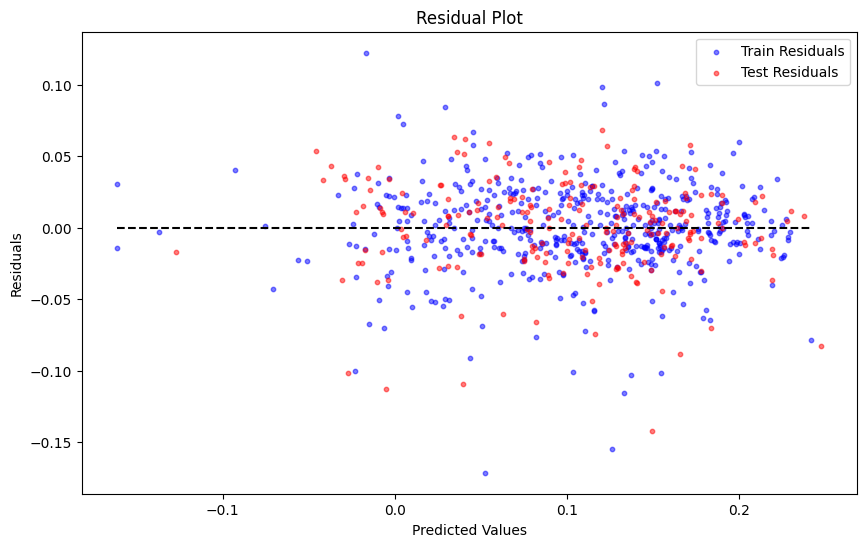

In [32]:
# Predictions
y_train_pred = ridge_reg.predict(X_train)
y_test_pred = ridge_reg.predict(X_test)

# Residuals
train_residuals = y_train - y_train_pred
test_residuals = y_test - y_test_pred

# Plotting residuals
plt.figure(figsize=(10, 6))
plt.scatter(y_train_pred, train_residuals, color='blue', s=10, alpha=0.5, label='Train Residuals')
plt.scatter(y_test_pred, test_residuals, color='red', s=10, alpha=0.5, label='Test Residuals')
plt.hlines(y=0, xmin=min(y_train_pred), xmax=max(y_train_pred), colors='k', linestyles='dashed')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.legend()
plt.show()

## Neural Network for Linear Regression

In [33]:
# Define the neural network model for linear regression with dropout
class LinearRegressionNN(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size, dropout_rate=0.5):
        super(LinearRegressionNN, self).__init__()
        # Define the layers
        self.fc1 = nn.Linear(input_size, hidden_sizes[0])
        self.fc2 = nn.Linear(hidden_sizes[0], hidden_sizes[1])
        self.fc3 = nn.Linear(hidden_sizes[1], hidden_sizes[2])
        self.fc4 = nn.Linear(hidden_sizes[2], output_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=dropout_rate)  # Dropout layer with the specified rate

    def forward(self, x):
        x = self.relu(self.fc1(x))  # Layer 1 with ReLU activation
        x = self.dropout(x)         # Apply dropout after the activation
        x = self.relu(self.fc2(x))  # Layer 2 with ReLU activation
        x = self.dropout(x)         # Apply dropout again
        x = self.relu(self.fc3(x))  # Layer 3 with ReLU activation
        x = self.fc4(x)             # Output layer without activation (for regression)
        return x

def train_and_test_model(model, train_loader, test_loader, epochs, learning_rate):
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    train_losses = []
    test_losses = []
    times = []

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        start_time = time.time()

        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            predictions = model(X_batch).squeeze(-1)  # Reshape model output
            loss = criterion(predictions, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        model.eval()
        test_loss = 0

        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                predictions = model(X_batch).squeeze(-1)  # Reshape model output
                loss = criterion(predictions, y_batch)
                test_loss += loss.item()

        test_loss /= len(test_loader)
        test_losses.append(test_loss)

        elapsed_time = time.time() - start_time
        times.append(elapsed_time)
        if epoch % 10 == 0:
          print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Time: {elapsed_time:.2f}s')

    return train_losses, test_losses, times

# Function to plot losses and training times
def plot_metrics(train_losses, test_losses, times):
    epochs = range(len(train_losses))

    # Plot Train and Test Loss
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, test_losses, label='Test Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Train and Test Loss over Epochs')
    plt.legend()

    # Plot Training Times per Epoch
    plt.subplot(1, 2, 2)
    plt.plot(epochs, times, label='Training Time per Epoch')
    plt.xlabel('Epochs')
    plt.ylabel('Time (seconds)')
    plt.title('Training Time per Epoch')
    plt.legend()

    plt.tight_layout()
    plt.show()


input_size = X_train.shape[1]   # Number of input features
hidden_sizes = [64, 32, 16]  # Number of neurons in hidden layers
output_size = 1  # Output size for regression (one continuous value)
dropout_rate = 0.5  # Dropout rate

Epoch 1/100, Train Loss: 0.0361, Test Loss: 0.0070, Time: 0.06s
Epoch 11/100, Train Loss: 0.0043, Test Loss: 0.0023, Time: 0.03s
Epoch 21/100, Train Loss: 0.0028, Test Loss: 0.0019, Time: 0.04s
Epoch 31/100, Train Loss: 0.0021, Test Loss: 0.0016, Time: 0.03s
Epoch 41/100, Train Loss: 0.0019, Test Loss: 0.0015, Time: 0.03s
Epoch 51/100, Train Loss: 0.0019, Test Loss: 0.0015, Time: 0.03s
Epoch 61/100, Train Loss: 0.0018, Test Loss: 0.0018, Time: 0.03s
Epoch 71/100, Train Loss: 0.0016, Test Loss: 0.0016, Time: 0.04s
Epoch 81/100, Train Loss: 0.0014, Test Loss: 0.0016, Time: 0.03s
Epoch 91/100, Train Loss: 0.0016, Test Loss: 0.0016, Time: 0.03s


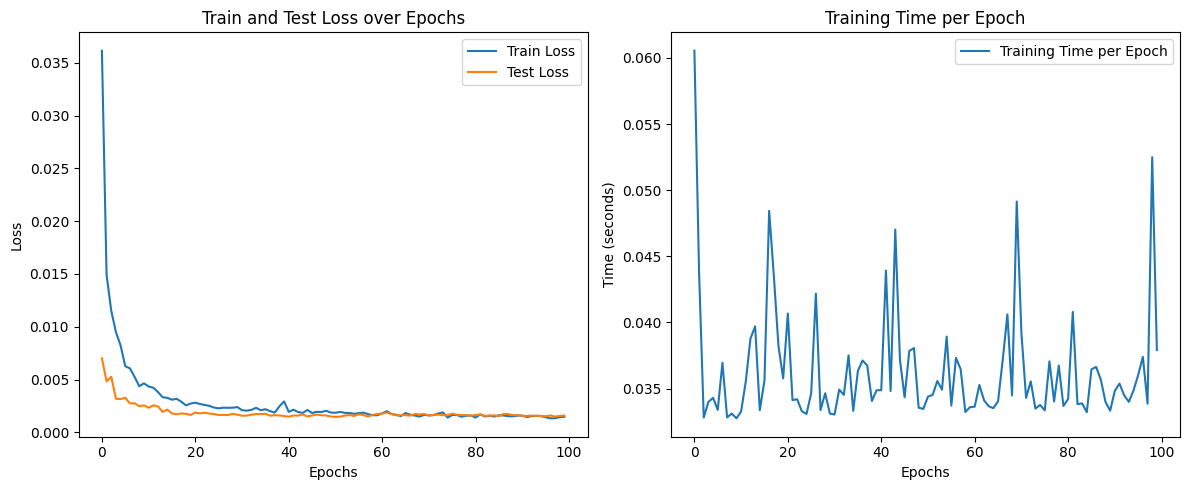

In [34]:
# Initialize the model
model = LinearRegressionNN(input_size, hidden_sizes, output_size, dropout_rate)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

# Create DataLoader objects for training and testing
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

# Train the model and capture the losses and times
train_losses, test_losses, times = train_and_test_model(model, train_loader, test_loader, epochs=100, learning_rate=0.001)

# Plot the metrics
plot_metrics(train_losses, test_losses, times)

# SVR

Fitting 5 folds for each of 32 candidates, totalling 160 fits
[CV] END .................C=0.1, epsilon=0.01, kernel=linear; total time=   0.1s
[CV] END .................C=0.1, epsilon=0.01, kernel=linear; total time=   0.1s
[CV] END .................C=0.1, epsilon=0.01, kernel=linear; total time=   0.1s
[CV] END .................C=0.1, epsilon=0.01, kernel=linear; total time=   0.1s
[CV] END .................C=0.1, epsilon=0.01, kernel=linear; total time=   0.1s
[CV] END ....................C=0.1, epsilon=0.01, kernel=rbf; total time=   0.0s
[CV] END ....................C=0.1, epsilon=0.01, kernel=rbf; total time=   0.0s
[CV] END ....................C=0.1, epsilon=0.01, kernel=rbf; total time=   0.0s
[CV] END ....................C=0.1, epsilon=0.01, kernel=rbf; total time=   0.0s
[CV] END ....................C=0.1, epsilon=0.01, kernel=rbf; total time=   0.0s
[CV] END ..................C=0.1, epsilon=0.1, kernel=linear; total time=   0.0s
[CV] END ..................C=0.1, epsilon=0.1, 

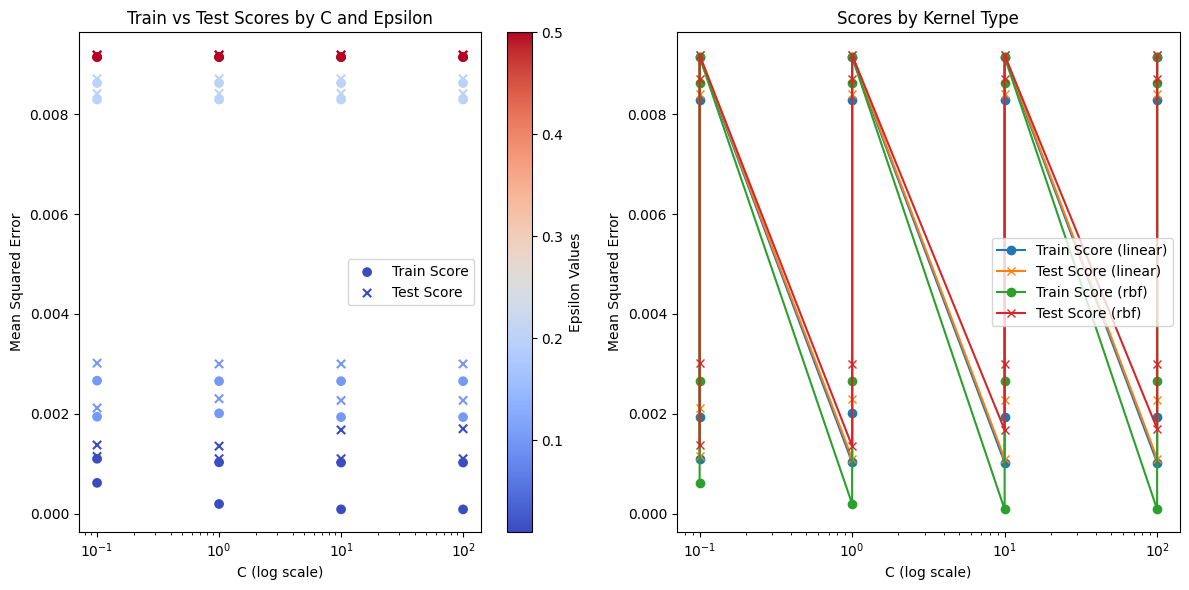

Best parameters found: {'C': 10, 'epsilon': 0.01, 'kernel': 'linear'}


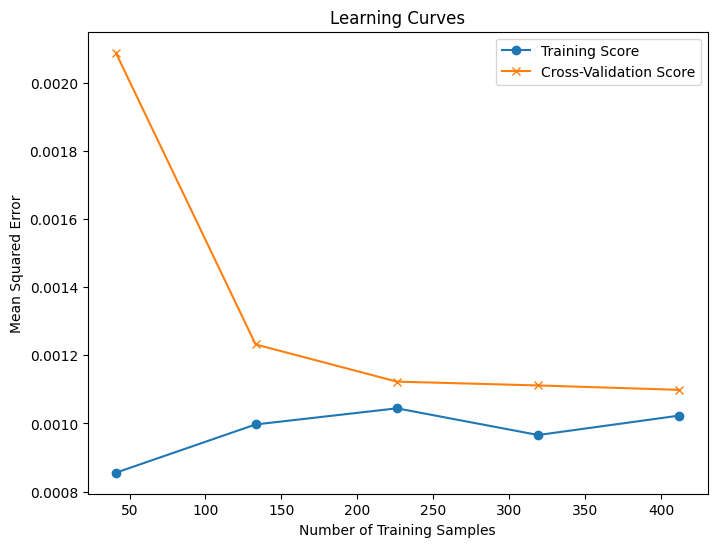

Best parameters found: {'C': 10, 'epsilon': 0.01, 'kernel': 'linear'}
Train MSE: 0.0010
Test MSE: 0.0010
Train R²: 0.8130
Test R²: 0.8010


In [35]:
# Standardize only the feature data (X_train and X_test)
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

# Initialise SVR
svr_model = SVR()

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'C': [0.1, 1, 10, 100],         # Regularization parameter
    'epsilon': [0.01, 0.1, 0.2, 0.5],  # Epsilon in the loss function
    'kernel': ['linear', 'rbf']      # Try both linear and RBF kernels
}

# Use custom scoring function with mean_squared_error
scorer = make_scorer(mean_squared_error, greater_is_better=False)

# Perform GridSearchCV for cross-validation
grid_search = GridSearchCV(estimator=svr_model, param_grid=param_grid, cv=5, scoring=scorer, verbose=2, return_train_score=True)

# Fit the model using cross-validation
grid_search.fit(X_train_scaled, y_train)

# Extract results from grid search
cv_results = grid_search.cv_results_

# Extract the parameter combinations and corresponding scores
mean_train_scores = -cv_results['mean_train_score']
mean_test_scores = -cv_results['mean_test_score']
param_combinations = cv_results['params']

# Convert parameters to arrays for plotting
C_values = np.array([param['C'] for param in param_combinations])
epsilon_values = np.array([param['epsilon'] for param in param_combinations])
kernel_values = np.array([param['kernel'] for param in param_combinations])

# Plot the Cross-Validation Results

# Plot Train vs. Test Scores by C and epsilon values
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(C_values, mean_train_scores, c=epsilon_values, cmap='coolwarm', marker='o', label='Train Score')
plt.scatter(C_values, mean_test_scores, c=epsilon_values, cmap='coolwarm', marker='x', label='Test Score')
plt.colorbar(label='Epsilon Values')
plt.xscale('log')
plt.xlabel('C (log scale)')
plt.ylabel('Mean Squared Error')
plt.title('Train vs Test Scores by C and Epsilon')
plt.legend()

# Plot Train vs. Test Scores by Kernel Type
plt.subplot(1, 2, 2)
for kernel in np.unique(kernel_values):
    mask = kernel_values == kernel
    plt.plot(C_values[mask], mean_train_scores[mask], label=f'Train Score ({kernel})', marker='o')
    plt.plot(C_values[mask], mean_test_scores[mask], label=f'Test Score ({kernel})', marker='x')

plt.xscale('log')
plt.xlabel('C (log scale)')
plt.ylabel('Mean Squared Error')
plt.title('Scores by Kernel Type')
plt.legend()

plt.tight_layout()
plt.show()

# Visualize the best hyperparameters found
best_params = grid_search.best_params_
print(f"Best parameters found: {best_params}")

# Plot Learning Curves (optional)
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(grid_search.best_estimator_, X_train_scaled, y_train, cv=5, scoring='neg_mean_squared_error')

mean_train_scores = -train_scores.mean(axis=1)
mean_test_scores = -test_scores.mean(axis=1)

plt.figure(figsize=(8, 6))
plt.plot(train_sizes, mean_train_scores, label='Training Score', marker='o')
plt.plot(train_sizes, mean_test_scores, label='Cross-Validation Score', marker='x')
plt.xlabel('Number of Training Samples')
plt.ylabel('Mean Squared Error')
plt.title('Learning Curves')
plt.legend()
plt.show()


# Use the best estimator from the grid search
best_model = grid_search.best_estimator_

# Make predictions on the train and test data
y_train_pred = best_model.predict(X_train_scaled)
y_test_pred = best_model.predict(X_test_scaled)

# Compute metrics
train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)

train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

# Print metrics
print(f"Best parameters found: {grid_search.best_params_}")
print(f"Train MSE: {train_mse:.4f}")
print(f"Test MSE: {test_mse:.4f}")
print(f"Train R²: {train_r2:.4f}")
print(f"Test R²: {test_r2:.4f}")
